In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib as plt

In [18]:
print(torch.__version__)

1.11.0


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
NVIDIA GeForce RTX 3060 Ti


In [20]:
torch.cuda.is_available()

True

In [21]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) 
                      ])

## download and load training dataset
trainset = torchvision.datasets.StanfordCars(root='./data',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

## download and load testing dataset
testset = torchvision.datasets.StanfordCars(root='./data',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

In [22]:
class_names = trainset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


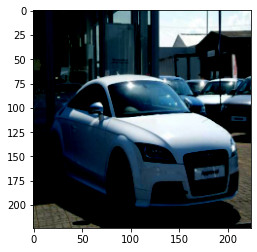

In [23]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainset)
images, labels = next(dataiter)


## show images
imshow(torchvision.utils.make_grid(images))

In [24]:
from torchvision.models.resnet import resnet18
model = resnet18(pretrained=True).to(device)

In [25]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,196)

In [26]:
model.fc.requires_grad_(False)
print(model.fc.weight.requires_grad)

False


In [27]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [28]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
for name, param in model.named_parameters():
    if name in ['fc.weight', 'fc.bias']:
        param.requires_grad = True

In [30]:
learning_rate = 0.001
num_epochs = 10
val_acc_history = []
val_loss_history = []
train_acc_history = []
train_loss_history = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(device)

cuda:0


In [31]:
import time
import os
import copy

In [32]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=1, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            print()

    
    


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history


In [33]:
train_model = train_model(model, trainloader, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 5.3376 Acc: 0.0114

val Loss: 5.1183 Acc: 0.0193

Epoch 1/9
----------
train Loss: 4.7817 Acc: 0.0260

val Loss: 4.4751 Acc: 0.0490

Epoch 2/9
----------
train Loss: 3.9415 Acc: 0.0927

val Loss: 3.5108 Acc: 0.1351

Epoch 3/9
----------
train Loss: 3.0312 Acc: 0.2084

val Loss: 2.7196 Acc: 0.2630

Epoch 4/9
----------
train Loss: 2.2128 Acc: 0.3800

val Loss: 1.9483 Acc: 0.4435

Epoch 5/9
----------
train Loss: 1.5049 Acc: 0.5583

val Loss: 1.5483 Acc: 0.5325

Epoch 6/9
----------
train Loss: 0.9548 Acc: 0.7177

val Loss: 0.7722 Acc: 0.7639

Epoch 7/9
----------
train Loss: 0.5467 Acc: 0.8448

val Loss: 0.5396 Acc: 0.8364

Epoch 8/9
----------
train Loss: 0.3336 Acc: 0.9099

val Loss: 0.5539 Acc: 0.8210

Epoch 9/9
----------
train Loss: 0.1813 Acc: 0.9570

val Loss: 0.1222 Acc: 0.9709

Training complete in 20m 34s
Best val Acc: 0.970899


In [34]:
train_acc_history = torch.tensor(train_acc_history)
train_loss_history = torch.tensor(train_loss_history)
val_acc_history = torch.tensor(val_acc_history)
val_loss_history = torch.tensor(val_loss_history)


In [35]:
print(train_acc_history)
print(train_loss_history)
print(val_acc_history)

tensor([0.0114, 0.0260, 0.0927, 0.2084, 0.3800, 0.5583, 0.7177, 0.8448, 0.9099,
        0.9570], dtype=torch.float64)
tensor([5.3376, 4.7817, 3.9415, 3.0312, 2.2128, 1.5049, 0.9548, 0.5467, 0.3336,
        0.1813])
tensor([0.0193, 0.0490, 0.1351, 0.2630, 0.4435, 0.5325, 0.7639, 0.8364, 0.8210,
        0.9709], dtype=torch.float64)


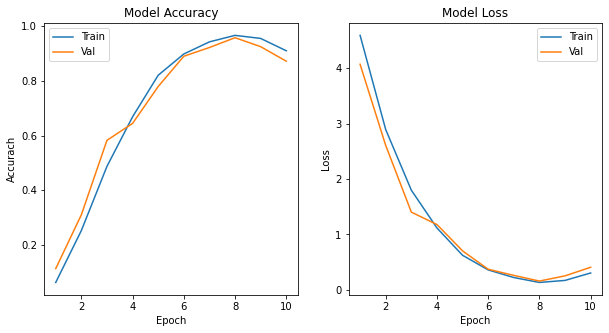

In [65]:

plt.figure(figsize=(10,5))
# 정확도 차트  
epoch_range = np.arange(1, 11)

plt.subplot(1, 2, 1)

plt.plot(epoch_range, train_acc_history)
plt.plot(epoch_range, val_acc_history)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accurach")
plt.legend( ['Train', 'Val']  )
# plt.show()

# loss 차트
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_loss_history)
plt.plot(epoch_range, val_loss_history)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend( ['Train', 'Val']  )

plt.show()